# Test for SDE GRN

Half life of proteins vary from minutes to months
http://biochimej.univ-angers.fr/Page2/COURS/Zsuite/3BiochMetab/7Ubiquitinylation/1Ubiquitinylation.htm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def noise(x,t):
    # Controls noise proportional to
    # square root of activity
    c = .1#4.
    return (c*np.sqrt(abs(x)))

def deltaW(N, m, h,seed=-1):
    """Generate sequence of Wiener increments for m independent Wiener
    processes W_j(t) j=0..m-1 for each of N time intervals of length h.    
    From the sdeint implementation

    :returns:
        - dW : The [n, j] element has the value W_j((n+1)*h) - W_j(n*h) ( has shape (N, m) )
    """
    if seed != -1:
        np.random.seed(seed)
    return np.random.normal(0.0, h, (N, m))

def step_eulersde(f, G, tn, yn, pars, dWn, h):
    yn_ = yn + f(yn, tn,pars)*h + np.multiply(G(yn, tn),dWn)
    # Ensure positive terms
    yn_ = np.maximum(yn_, 0)

    return yn_

def eulersde(f,G,y0,tspan,pars,seed=-1,dW=None):
    """
    Adapted from sdeint implementation https://github.com/mattja/sdeint/

    :param f: function defining ODE model. Should take vector of current state, current time, and list of parameter values as arguments.
    :type f: function
    :param pars: List of parameter values
    :type pars: list
    :param y0: list of initial values
    :type y0: list
    :param tspan: Array of timepoints to simulate
    :type tspan: ndarray
    :param seed: Seed to initialize random number generator
    :type seed: float
    :returns:
        - y: Array containing the time course of state variables 
    """
    # From sdeint implementation
    N = len(tspan)
    h = (tspan[N-1] - tspan[0])/(N - 1)
    maxtime = tspan[-1]
    # allocate space for result
    d = len(y0)
    y = np.zeros((N+1, d), dtype=type(y0[0]))

    if dW is None:
        # pre-generate Wiener increments (for d independent Wiener processes):
        dW = deltaW(N, d, h, seed=seed)
    y[0] = y0
    currtime = 0
    n = 0
   
    while currtime < maxtime:
        # f, G, tn, yn, pars, dWn, h
        y[n+1] = step_eulersde(f, G, currtime, y[n], pars, dW[n], h)
        # Ensure positive terms
        currtime += h
        n += 1
    return y

def getInitialCondition(ss, ModelSpec, rnaIndex,
                        proteinIndex,
                        genelist, proteinlist,
                        varmapper,revvarmapper):
    """
    Calculate the initial values of all state variables. 
    Takes into consideration user defined initial conditions, and computes the steady 
    states of the protein variables based on the estimated values of their corresponding genes.

    :param ss: Steady state array
    :type ss: ndarray
    :param ModelSpec: Dictionary of dictionary specifying the ODE model, containing parameters, initial conditions and equations.
    :type ModelSpec: dict
    :param rnaIndex: list of indices of genes
    :type rnaIndex: list
    :param proteinIndex: List of indices of proteins
    :type proteinIndex: list
    :param genelist: List of names of all genes in the model
    :type genelist: list
    :param proteinlist: List of names of all proteins in the model
    :type proteinlist: list
    :param varmapper: Mapper: {variable name : index}
    :type varmapper: dict
    :param revvarmapper: Mapper: {index : variable name}
    :type revvarmapper: dict
    :returns:
        - newics: List containing new initial conditions
    """

    # Initialize
    new_ics = [0 for _ in range(len(varmapper.keys()))]
    # Set the mRNA ics
    for ind in rnaIndex:
        if ss[ind] < 0:
            ss[ind] = 0.0
        new_ics[ind] =  ss[ind]
        if new_ics[ind] < 0:
            new_ics[ind] = 0
    for p in proteinlist:
        ind = revvarmapper['p_'+p]
        if ss[ind] < 0:
            ss[ind] = 0.0
        new_ics[ind] =  ss[ind]
        if new_ics[ind] < 0:
            new_ics[ind] = 0            
    # Calculate the Protein ics based on mRNA levels
    for genename in genelist:
        pss = ((ModelSpec['pars']['r_' + genename])/\
                                      (ModelSpec['pars']['l_p_' + genename]))\
                                      *new_ics[revvarmapper['x_' + genename]]
        new_ics[revvarmapper['p_' + genename.replace('_','')]] = pss
    return(new_ics)


In [3]:
#####################################################

# This file is created automatically
def Model(Y,t,pars):
    # Parameters
    a_A = pars[0]
    a_B = pars[1]
    a_C = pars[2]

    k_A = pars[3]
    k_B = pars[4]
    k_C = pars[5]

    l_p_A = pars[6]
    l_p_B = pars[7]
    l_p_C = pars[8]

    l_A = pars[9]
    l_B = pars[10]
    l_C = pars[11]

    m_A = pars[12]
    m_B = pars[13]
    m_C = pars[14]

    n_A = pars[15]
    n_B = pars[16]
    n_C = pars[17]

    r_A = pars[18]
    r_B = pars[19]
    r_C = pars[20]


    # Variables
    A = Y[0]
    p_A = Y[1]
    B = Y[2]
    p_B = Y[3]
    C = Y[4]
    p_C = Y[5]
    
    y_A = (p_A/k_A)**n_A
    y_B = (p_B/k_B)**n_B
    y_C = (p_C/k_C)**n_C

    dA = m_A*(( a_A + y_A)/( 1 + y_B + y_A + y_C))-l_A*A
    dp_A = r_A*A- l_p_A*p_A
    
    dB = m_B*(( a_B + y_A + y_B ) / ( 1 + y_A + y_B + y_C))-l_B*B
    dp_B = r_B*B- l_p_B*p_B
    
    dC = m_C*(( a_C + y_B + y_C)/( 1 + y_B + y_C))-l_C*C
    dp_C = r_C*C- l_p_C*p_C

    dY = np.array([dA,dp_A,dB,dp_B,dC,dp_C,])
    return(dY)
#####################################################

In [4]:
def get_pars():
    a_A = 0.1
    a_B = 0.1
    a_C = 0

    k_A = 3
    k_B = 3
    k_C = 3

    l_p_A = 0.1
    l_p_B = 0.1
    l_p_C = 0.1

    l_A = 1
    l_B = 1.2
    l_C = 1.2

    m_A = 2
    m_B = 2
    m_C = 1.7

    n_A = 3
    n_B = 3
    n_C = 3

    r_A = 0.5
    r_B = 0.5
    r_C = 0.5
    
    return [a_A, a_B, a_C, k_A, k_B, k_C, l_p_A, l_p_B, l_p_C, l_A, l_B, l_C,
           m_A, m_B, m_C, n_A, n_B, n_C, r_A, r_B, r_C]

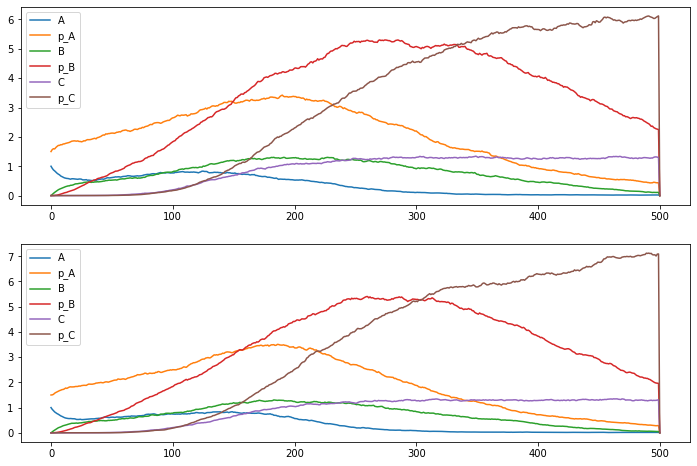

In [17]:
pars = get_pars()
G = noise
tspan = np.arange(0, 50, 0.1)
y0 = np.array([1., 1.5, 0., 0., 0., 0.])

vals = eulersde(Model, G, y0, tspan, pars)

i = 6
idx = 3*i+2
pars[idx] *= 1.1
vals1 = eulersde(Model, G, y0, tspan, pars)

names = ["A", "p_A", "B", "p_B", "C", "p_C"]
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for i in range(vals.shape[1]):
    plt.plot(vals[:, i], label=names[i])
    
plt.legend()

names = ["A", "p_A", "B", "p_B", "C", "p_C"]
plt.subplot(2, 1, 2)
for i in range(vals.shape[1]):
    plt.plot(vals1[:, i], label=names[i])
    
plt.legend()

## Conclusion

Gene Regulatory Network is working, however we need to refer to Alon to properly design it and tune the parameters.

We will have to implement hyperopt pipeline in order to optimize the differentiation progression

[0.1, 0.1, 0, 3, 3, 3, 0.1, 0.1, 0.1, 1, 1.2, 1, 2, 2, 1.8, 3, 3, 3, 0.5, 0.5, 0.5]


In [6]:
print(get_pars())

[0.1, 0.1, 0, 3, 3, 3, 0.1, 0.1, 0.1, 1, 1.2, 1.2, 2, 2, 1.7, 3, 3, 3, 0.5, 0.5, 0.5]
